# 1. Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regres-
sion to predict the amount of water flowing out of a dam using the change
of water level in a reservoir. In the next half, you will go through some diag-
nostics of debugging learning algorithms and examine the effects of bias v.s.
variance.

In [332]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
%matplotlib inline

## 1.1 Visualizing the dataset
We will begin by visualizing the dataset containing historical records on the
change in the water level, x, and the amount of water flowing out of the dam,
y.
This dataset is divided into three parts:

• A training set that your model will learn on: X, y

• A cross validation set for determining the regularization parameter:
Xval, yval

• A test set for evaluating performance. 

These are “unseen” examples
which your model did not see during training: Xtest, ytest
The next step of ex5.m will plot the training data (Figure 1). In the
following parts, you will implement linear regression and use that to fit a
straight line to the data and plot learning curves. Following that, you will
implement polynomial regression to find a better fit to the data.

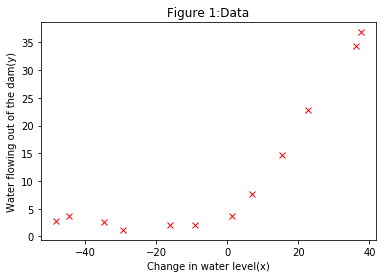

(12, 1)


In [333]:
#Loading and Visualizing Data

#Load Training Data
dataFile='ex5data1.mat'
data=scio.loadmat(dataFile)
X=data['X']
y=data['y']
Xval=data['Xval']
yval=data['yval']
Xtest=data['Xtest']
ytest=data['ytest']

#m=Number of examples of traning set
m=X.shape[0]

#Plot training data
def plot_data(X,y):
    plt.plot(X,y,'rx')
    plt.xlabel('Change in water level(x)')
    plt.ylabel('Water flowing out of the dam(y)')
    plt.title('Figure 1:Data')

plot_data(X,y)
plt.show()
print(X.shape)

In [334]:
X_origin=X
X=np.hstack((np.ones((m,1)),X))
Xval_origin=Xval
Xval=np.hstack((np.ones((Xval.shape[0],1)),Xval))
Xtest_origin=Xtest
Xtest=np.hstack((np.ones((Xtest.shape[0],1)),Xtest))
print(X.shape)

(12, 2)


## 1.2 Regularized linear regression cost function
Recall that regularized linear regression has the following cost function:
$$J(\theta)=\frac{1}{2m}(\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^{2})+\frac{\lambda}{2m}(\sum_{j=1}^{n}\theta_{j}^{2})$$

## 1.3 Regularized linear regression gradient
Correspondingly, the partial derivative of regularized linear regression’s cost for θ j is defined as

for j=0:
$$\frac{\partial J(\theta)}{\partial \theta_{0}}=\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}$$

for j>=1
$$\frac{\partial J(\theta)}{\partial \theta_{j}}=\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}+\frac{\lambda}{m}\theta_{j}$$

In [335]:
def h(X,theta):
    res=np.dot(X,theta)
    return res
def linearRegCostFunction(theta,X,y,lambd):
    theta=theta.reshape(theta.shape[0],1)
    m=X.shape[0] #number of training examples
    J=(1/(2*m))*(np.sum((h(X,theta)-y)**2)+lambd*np.sum(theta[1:,:]**2))
    grad=(1/m)*np.dot(X.T,h(X,theta)-y)
    grad[1:,:]+=(lambd/m)*theta[1:,:]
    return J,grad.ravel()

#test the cost of linearRegCostFunction
theta_test=np.array([[1],[1]])
J_test=linearRegCostFunction(theta_test,X,y,1)[0]
print('Cost at theta=[1;1] with lambda=1 should be about 303.993192,\
and my cost value is',J_test)
#test the grad of linearRegCostFunction
grad_test=linearRegCostFunction(theta_test,X,y,1)[1]
print('Gradient at theta=[1;1] with lambda=1 should be about \
[-15.303016;598.250744],my grad value is',grad_test)
print(X.shape)

Cost at theta=[1;1] with lambda=1 should be about 303.993192,and my cost value is 303.99319222
Gradient at theta=[1;1] with lambda=1 should be about [-15.303016;598.250744],my grad value is [ -15.30301567  598.25074417]
(12, 2)


## 1.4 Fitting linear regression
In this part, we set regularization parameter λ to zero. Because our
current implementation of linear regression is trying to fit a 2-dimensional θ,
regularization will not be incredibly helpful for a θ of such low dimension. In
the later parts of the exercise, you will be using polynomial regression with
regularization.

In [336]:
#Train Linear Regression
def trainLinearReg(X,y,lambd):
    '''this function returns the theta after training'''
    #initialize Theta
    initial_theta=np.zeros((X.shape[1],1))
    #using scipy.optimize.minimize to minimize costfunction
    optimizeResult=minimize(fun=linearRegCostFunction,x0=initial_theta.ravel(),\
                           args=(X,y,lambd),method='TNC',jac=True,\
                           options={'maxiter':400})
    theta=optimizeResult.x
    theta=theta.reshape(theta.shape[0],1)
    return theta
#training linear regression with lambda=0
lambd=0
theta=trainLinearReg(X,y,lambd)
print(theta.shape)
print(X.shape)

(2, 1)
(12, 2)


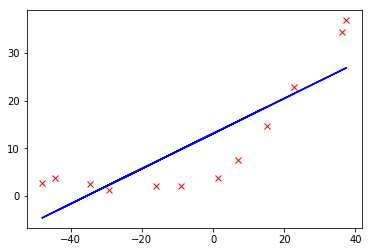

In [337]:
#Plot fit over the data
def plot_linear(X,y,theta):
    X_origin=np.hsplit(X,(1,))[1]
    plt.plot(X_origin,y,'rx',label='training set')
    m=X.shape[0]
    plt.plot(X_origin,h(X,theta),'b-',label='linear regression')
plot_linear(X,y,theta)
plt.show()

# 2 Bias-variance
An important concept in machine learning is the bias-variance tradeoff. Mod-
els with high bias are not complex enough for the data and tend to underfit,
while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a
learning curve to diagnose bias-variance problems.

## 2.1 Learning curves
You will now implement code to generate the learning curves that will be
useful in debugging learning algorithms. Recall that a learning curve plots
training and cross validation error as a function of training set size. Your
job is to fill in learningCurve.m so that it returns a vector of errors for the
training set and cross validation set.

To plot the learning curve, we need a training and cross validation set
error for different training set sizes. To obtain different training set sizes,
you should use different subsets of the original training set X. Specifically, for
a training set size of i, you should use the first i examples (i.e., X(1:i,:)
and y(1:i)).

You can use the trainLinearReg function to find the θ parameters. Note
that the lambda is passed as a parameter to the learningCurve function.
After learning the θ parameters, you should compute the error on the train-
ing and cross validation sets. Recall that the training error for a dataset is
defined as
$$J_{train}(\theta)=\frac{1}{2m}[\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^{2}]$$
In particular, note that the training error does not include the regular-
ization term. One way to compute the training error is to use your existing
cost function and set λ to 0 only when using it to compute the training error
and cross validation error. When you are computing the training set error,
make sure you compute it on the training subset (i.e., X(1:n,:) and y(1:n))
(instead of the entire training set). However, for the cross validation error,
you should compute it over the entire cross validation set. You should store
the computed errors in the vectors error train and error val.

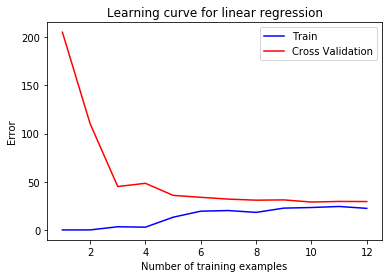

In [338]:
#Learning Curve for Linear Regresson
def learningCurve(X,y,Xval,yval,lambd):
    '''this function will return error of train set(m from 1 to m) 
    and the error of cross validation set(m from 1 to m)
    i.e. error_train(i) and error_val(i) should give the errors obtained
    after training on i examples'''
    
    #Number of training examples
    m=X.shape[0]
    #Return these values
    error_train=np.zeros((m,1))
    error_val=np.zeros((m,1))
    #use a for-loop to compute error_train and error_val
    for i in range(1,m+1):
        X_train=X[0:i,:]
        y_train=y[0:i,:]
        theta=trainLinearReg(X_train,y_train,lambd)
        error_train[i-1][0]=linearRegCostFunction(theta,X_train,y_train,0)[0]#set lambda=0
        error_val[i-1][0]=linearRegCostFunction(theta,Xval,yval,0)[0]#set lambda=0
    return error_train,error_val

lambd=0
error_train,error_val=learningCurve(X,y,Xval,yval,lambd)
#plot the learning curve
plt.plot(np.arange(1,m+1),error_train,'b-',label='Train')
plt.plot(np.arange(1,m+1),error_val,'r-',label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.legend()
plt.show()

# 3. Ploynomial regression
The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, you will
address this problem by adding more features.

For use polynomial regression, our hypothesis has the form:
$$h_{\theta}(x)=\theta_{0}+\theta_{1}*(waterLevel)+\theta_{2}*(waterLevel)^{2}+......+\theta_{p}*(waterLevel)^{p}$$
$$=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+......+\theta_{p}x_{p}$$
Notice that by defining x 1 = (waterLevel), x 2 = (waterLevel) 2 , . . . , x p =
(waterLevel) p , we obtain a linear regression model where the features are the
various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing
feature x in the dataset. Your task in this part is to complete the code in
polyFeatures.m so that the function maps the original training set X of size
m × 1 into its higher powers. Specifically, when a training set X of size m × 1
is passed into the function, the function should return a m×p matrix X poly,where column 1 holds the original values of X, column 2 holds the values of
X.^2, column 3 holds the values of X.^3, and so on. Note that you don’t
have to account for the zero-eth power in this function.

Now you have a function that will map features to a higher dimension,
and Part 6 of ex5.m will apply it to the training s

## 3.1 Learning Polynomial Regression

In [339]:
#Feature Mapping for Polynomial Regression
def polyFeatures(X,p):
    '''Given a vector X,return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power'''
    X_poly=X
    for i in range(2,p+1):
        X_poly=np.hstack((X_poly,X**i))
    return X_poly
def featureNormalize(X):
    mu=np.mean(X,axis=0) #compute the average of every column
    X_norm=X-mu
    sigma=np.std(X_norm,ddof=1,axis=0) #计算每一列的标准差
    X_norm=X_norm/sigma
    return X_norm,mu,sigma
    
p=8
#Map X onto Polynomial Features and Normalize
X_poly=polyFeatures(X_origin,p)
X_poly,mu,sigma=featureNormalize(X_poly) #Normalize
X_poly=np.hstack((np.ones((X_poly.shape[0],1)),X_poly))#Add ones
print(X_poly[:3,:])

#Map X_poly_test and normalize(using mu and sigma)
X_poly_test=polyFeatures(Xtest_origin,p)
X_poly_test=(X_poly_test-mu)/sigma
X_poly_test=np.hstack((np.ones((X_poly_test.shape[0],1)),X_poly_test))#Add ones

#Map X_poly_val and normalize (using mu and sigma)
X_poly_val=polyFeatures(Xval_origin,p)
X_poly_val=(X_poly_val-mu)/sigma
X_poly_val=np.hstack((np.ones((X_poly_val.shape[0],1)),X_poly_val))#Add ones


[[  1.00000000e+00  -3.62140776e-01  -7.55086688e-01   1.82225876e-01
   -7.06189908e-01   3.06617917e-01  -5.90877673e-01   3.44515797e-01
   -5.08481165e-01]
 [  1.00000000e+00  -8.03204845e-01   1.25825266e-03  -2.47936991e-01
   -3.27023420e-01   9.33963187e-02  -4.35817606e-01   2.55416116e-01
   -4.48912493e-01]
 [  1.00000000e+00   1.37746700e+00   5.84826715e-01   1.24976856e+00
    2.45311974e-01   9.78359696e-01  -1.21556976e-02   7.56568484e-01
   -1.70352114e-01]]


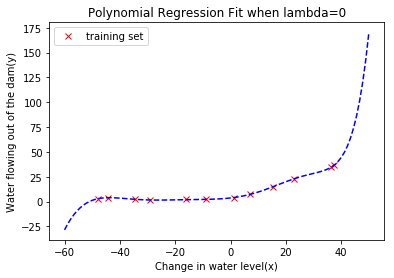

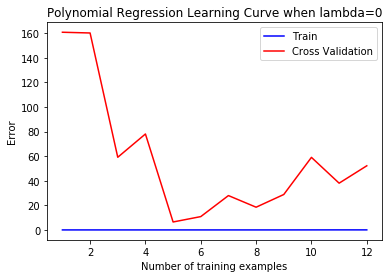

In [340]:
# Learning Curve for Polynomial Regression
lambd=0
theta=trainLinearReg(X_poly,y,lambd)

#Plot training data and fit
def plot_poly(theta,X,y,mu,sigma,lambd):
    plt.plot(X[:,1:],y,'rx',label='training set')
    x_fig=np.linspace(-60,50,100)
    x_fig=x_fig.reshape(x_fig.shape[0],1)
    #Map x_poly and normalize
    x_poly=polyFeatures(x_fig,8)
    x_poly=(x_poly-mu)/sigma
    x_poly=np.hstack((np.ones((100,1)),x_poly))#add ones
    y_fig=h(x_poly,theta)
    plt.plot(x_fig,y_fig,'b--')
    plt.xlabel('Change in water level(x)')
    plt.ylabel('Water flowing out of the dam(y)')
    plt.title('Polynomial Regression Fit when lambda='+str(lambd))
    plt.legend()
def plot_poly_error(X_poly,y,X_poly_val,yval,lambd):
    error_train,error_val=learningCurve(X_poly,y,X_poly_val,yval,lambd)
    plt.plot(np.arange(1,m+1),error_train,'b-',label='Train')
    plt.plot(np.arange(1,m+1),error_val,'r-',label='Cross Validation')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Polynomial Regression Learning Curve when lambda='+str(lambd))
    plt.legend()
plot_poly(theta,X,y,mu,sigma,lambd)
plt.show()
plot_poly_error(X_poly,y,X_poly_val,yval,lambd)
plt.show()

## 3.2 Adjusting the regularization parameter
n this section, you will get to observe how the regularization parameter
affects the bias-variance of regularized polynomial regression. You should
now modify the the lambda parameter in the ex5.m and try λ = 1, 100. For
each of these values, the script should generate a polynomial fit to the data
and also a learning curve.

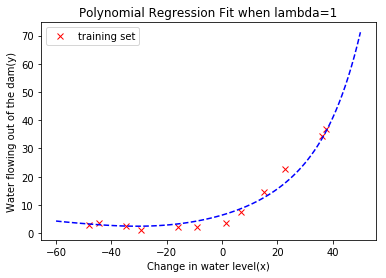

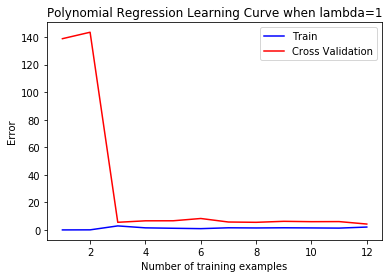

In [341]:
#plot the figures when lambda=1
lambd=1
theta=trainLinearReg(X_poly,y,lambd)
plot_poly(theta,X,y,mu,sigma,lambd)
plt.show()
plot_poly_error(X_poly,y,X_poly_val,yval,lambd)
plt.show()

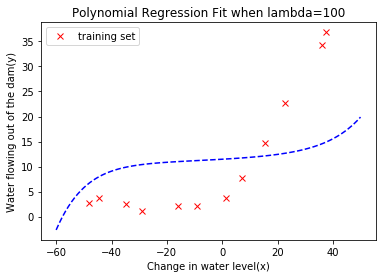

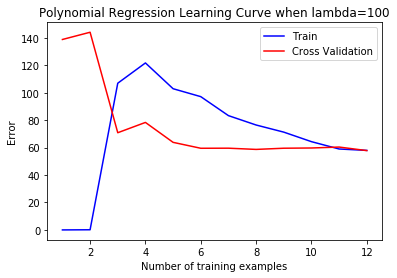

In [342]:
#plot the figures when lambda=100
lambd=100
theta=trainLinearReg(X_poly,y,lambd)
plot_poly(theta,X,y,mu,sigma,lambd)
plt.show()
plot_poly_error(X_poly,y,X_poly_val,yval,lambd)
plt.show()

## 3.3 Selecting $\lambda$ using a cross validation set
In this section, you will implement an automated method to select the
λ parameter. Concretely, you will use a cross validation set to evaluate
how good each λ value is. After selecting the best λ value using the cross
validation set, we can then evaluate the model on the test set to estimate
how well the model will perform on actual unseen data.

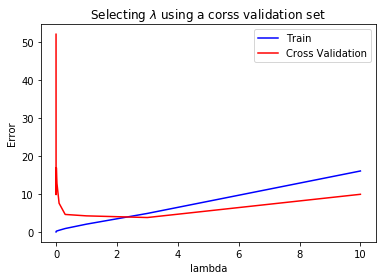

In [343]:
# Validation for Selecting Lambda
def validationCurve(X,y,Xval,yval):
    '''Fill in this function to return training errors in error_train 
    and the validation errors in error_val. The vector lambda_vec 
    contains the different lambda parameters to use for each 
    calculation of the errors, i.e, error_train(i), and error_val(i) 
    should give you the errors obtained after training with lambda = 
    lambda_vec(i)'''
    # Selected values of lambda
    lambda_vec=np.array([0,0.001,0.001,0.01,0.03,0.1,0.3,1,3,10])
    #variables that need to be returned
    error_train=np.zeros((lambda_vec.shape[0],1))
    error_val=np.zeros((lambda_vec.shape[0],1))
    for i in range(lambda_vec.shape[0]):
        lambd=lambda_vec[i]
        theta=trainLinearReg(X,y,lambd)
        error_train[i]=linearRegCostFunction(theta,X,y,0)[0]
        error_val[i]=linearRegCostFunction(theta,Xval,yval,0)[0]
    return lambda_vec,error_train,error_val

lambda_vec,error_train,error_val=validationCurve(X_poly,y,X_poly_val,yval)
#plot the figure
plt.plot(lambda_vec,error_train,'b-',label='Train')
plt.plot(lambda_vec,error_val,'r-',label='Cross Validation')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.title('Selecting $\lambda$ using a corss validation set')
plt.legend()
plt.show()

## 3.4 Computing test set error

In [344]:
lambd=3
theta=trainLinearReg(X_poly,y,lambd)
error=linearRegCostFunction(theta,X_poly_test,ytest,0)[0]
print('The error of lambda=3 of test set is about 3.8599,my error value is',error)

The error of lambda=3 of test set is about 3.8599,my error value is 3.85989952364
